In [1]:
# importing data

from typing import List, Dict, Tuple, Callable
import os
import gc
import traceback
import warnings
from pdb import set_trace

import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

bankdf = pd.read_csv('bank_data.csv',sep=";")

In [2]:
bankdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

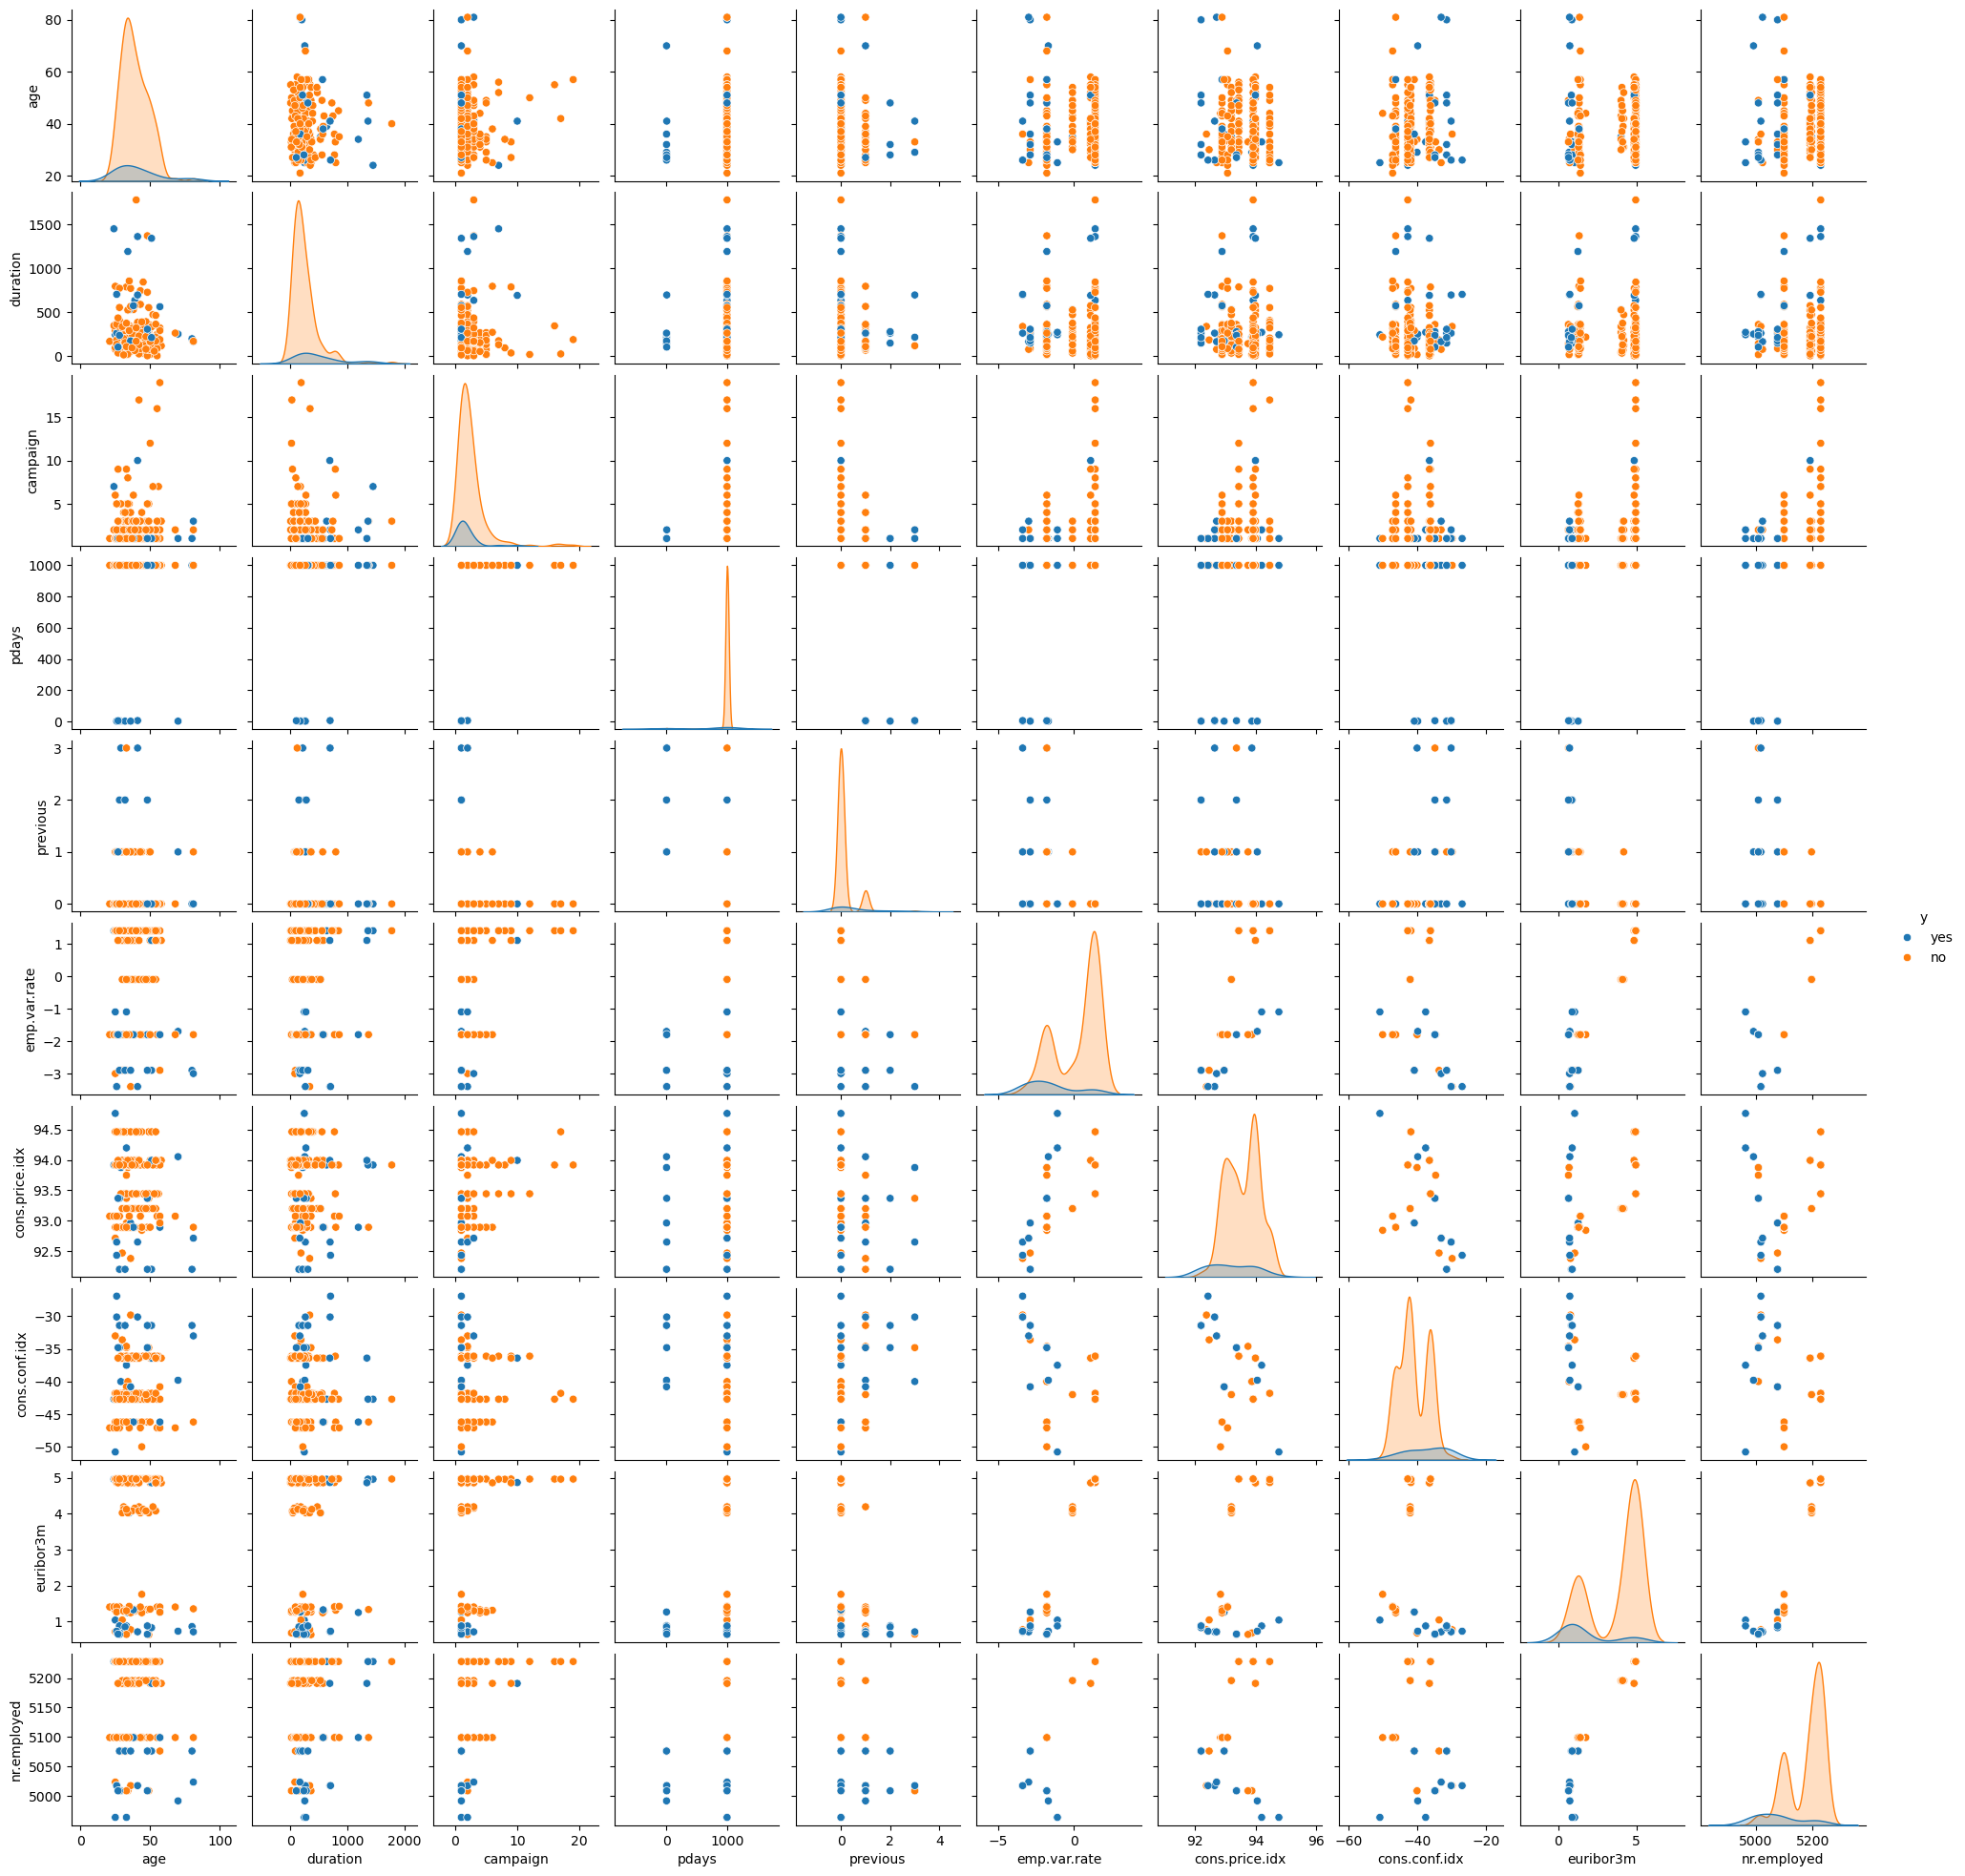

In [20]:
from seaborn import pairplot
rng = np.random.RandomState(0)
indices = rng.choice(np.arange(len(bankdf)), size=200, replace=False)
pairplot(bankdf.iloc[indices], hue='y', height=2)

In [22]:
bankdf.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [24]:
loan_options = {0:'no',1:'yes',2:'no'}
contact_options = {0: 'cellular',1:'telephone'}
"""
Used this to figure out the categories in job:
job = list(set(list(data.iloc[:,1])))
print(job)"""
job_options = {0:'admin.', 1:'self-employed', 2:'student', 3:'unknown', 4:'management', 5:'unemployed', 6:'entrepreneur', 7:'blue-collar', 8:'technician', 9:'services', 10:'housemaid', 11:'retired'}
marital_options = {0:'married',1:'single',2:'divorced'}
"""
education = list(set(list(data.iloc[:,3])))
print(education)"""
education_options = {0:'basic.6y', 1:'basic.9y', 2:'illiterate', 3:'basic.4y', 4:'high.school', 5:'university.degree', 6:'professional.course'}
default_options = {0:'no',1:'unknown'}
housing_options = {0:'yes',1:'no',2:'unknown'}
month_options = {0:'jan',1:'feb',2:'mar',3:'apr',4:'may',5:'jun',6:'jul',7:'aug',8:'sep',9:'oct',10:'nov',11:'dec'}
day_options = {0:'mon',1:'tue',2:'wed',3:'thu',4:'fri'}
poutcome_options = {0:'nonexistent',1:'failure',2:'success'}

yes_no = {0:'yes',1:'no'}

In [26]:
X = bankdf.drop('y',axis=1)

X = pd.get_dummies(X, columns=['job', 'marital','education','default','housing','loan','contact','month','day_of_week','poutcome'], drop_first=True,dtype=int).values
    
y = bankdf['y']

y = pd.get_dummies(y, columns=['y'], drop_first=True,dtype=int).values

In [28]:
print(X)

[[ 56. 261.   1. ...   0.   1.   0.]
 [ 57. 149.   1. ...   0.   1.   0.]
 [ 37. 226.   1. ...   0.   1.   0.]
 ...
 [ 56. 189.   2. ...   0.   1.   0.]
 [ 44. 442.   1. ...   0.   1.   0.]
 [ 74. 239.   3. ...   0.   0.   0.]]


In [30]:
print(y)

[[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]


In [32]:
# Using perceptron

In [34]:
def binarize_classes(
    X: np.ndarray,
    y: np.ndarray,
    pos_class: List[int], 
    neg_class: List[int]
) -> Tuple[np.ndarray, np.ndarray]:
    """ Converts data into a one-vs-all or one-vs-one prolbem
        according to labels passed as pos or neg.

        Args:
            X: Input data given as matrix

            y: Labels corresponding to input data given as 1D vector

            pos_class: list of labels that will be used for 
                the positive class.

            neg_class: list of labels that will be used for 
                the negative class.

        Returns:
            Two arrays where the 1st corresponds to the data
            given as a matrix and the 2nd corresponds to the
            new labels given as a 1D vector.
    """
    assert isinstance(X, np.ndarray), f"X is not an NumPy array, got type {type(X)}."
    assert isinstance(y, np.ndarray), f"y is not an NumPy array, got type {type(y)}."
    X = X.copy()
    y = y.copy()
    
    # TODO 2.1
    X_pos, y_pos = X[np.isin(y,pos_class)], y[np.isin(y,pos_class)]
    y_pos[:] = 1
    
    
    # TODO 2.2
    X_neg, y_neg = X[np.isin(y,neg_class)], y[np.isin(y,neg_class)]
    y_neg[:] = -1
    
    
    return np.vstack([X_pos, X_neg]), np.hstack([y_pos, y_neg])

In [36]:
from sklearn.model_selection import train_test_split
def get_train_valid_test_data(
    X: np.ndarray, 
    y: np.ndarray, 
):
    """ Randomizes and then splits the data into train, validation, and test sets.

        Args:
            X: Data given as a 2D matrix

            y: Labels given as a vector 
    """
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size=.8, random_state=42)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, train_size=.8, random_state=42)

    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

In [38]:
def get_preprocessed_data(input, output, pos_class: List[int], neg_class: List[int])  -> Tuple[np.ndarray]:
    """ Gets preprocessed data for training, validation, and testing

        Args:
            pos_class: list of labels that will be used for 
                the positive class.

            neg_class: list of labels that will be used for 
                the negative class.

        Return:
            A tuple of NumPy arrays where indices 0-1 
            contain the training data/targets, indices 2-3
            contain the validation data/targets, and 4-5
            contain the testing data/targets.
    """
    # TODO 3.1
    
    # TODO 3.2
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst= get_train_valid_test_data(input,output)
    

    # TODO 3.3
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(X_trn)
    X_trn, X_vld, X_tst = scaler.transform(X_trn),scaler.transform(X_vld),scaler.transform(X_tst)
    
    # TODO 3.4
    bias = np.ones(np.shape(X_trn)[0])
    X_trn = np.column_stack((bias,X_trn))

    bias = np.ones(np.shape(X_vld)[0])
    X_vld = np.column_stack((bias,X_vld))
    
    bias = np.ones(np.shape(X_tst)[0])
    X_tst = np.column_stack((bias,X_tst))

    # Reshape targets to be 2D column vectors
    return X_trn, y_trn.reshape(-1, 1), X_vld, y_vld.reshape(-1, 1), X_tst, y_tst.reshape(-1, 1)

In [40]:
def accuracy(y: np.ndarray, y_hat: np.ndarray) -> float:
    """ Computes the accuracy between two 1D vectors

        Args:
            y: Ground truth labels given as a 1D vector

            y_hat: Predicted labels given as a 1D vector

        Return:
            A float corresponding to the accuracy
    """
    y =  y.flatten() # reshape to make 1D vector for consistency
    y_hat = y_hat.flatten() # reshape to make 1D vector for consistency

    # TODO 4

    accuracy = np.sum(y_hat == y) / np.shape(y)[0]
    
    return accuracy

In [44]:
def ppv(y: np.ndarray, y_hat: np.ndarray) -> float:
    """ Compute the PPV or precision score

        Args:
            y: Ground truth labels given as a 1D vector

            y_hat: Predicted labels given as a 1D vector

        Returns:
            A float corresponding to the PPV value.
    """
    y =  y.flatten() # reshape to make 1D vector for consistency
    y_hat = y_hat.flatten() # reshape to make 1D vector for consistency
    
    # TODO 6

    cfm = sklearn.metrics.confusion_matrix(y_true = y,y_pred = y_hat)
    tp, fp = cfm[1,1], cfm[0,1]
    
    return tp / (tp + fp)

In [46]:
def tpr(y: np.ndarray, y_hat: np.ndarray) -> float:
    """ Compute the TPR or recall score

        Args:
            y: Ground truth labels given as a 1D vector

            y_hat: Predicted labels given as a 1D vector

        Returns:
            A float corresponding to the TPR value.
    """
    # TODO 7

    cfm = sklearn.metrics.confusion_matrix(y_true = y,y_pred = y_hat)
    tp, fn = cfm[1,1], cfm[1,0]
    
    return tp / (tp + fn)

In [47]:
def tnr(y: np.ndarray, y_hat: np.ndarray) -> float:
    """ Compute the TNR or specificity score

        Args:
            y: Ground truth labels given as a 1D vector

            y_hat: Predicted labels given as a 1D vector

        Returns:
            A float corresponding to the TNR value.
    """
    # TODO 8
    
    cfm = sklearn.metrics.confusion_matrix(y_true = y,y_pred = y_hat)
    tn, fp = cfm[0,0], cfm[0,1]
    
    return tn / (tn + fp)

In [50]:
class Perceptron():
    """ Performs binary classification using Rosenblatt's perceptron
    
        Attributes:

            alpha: learning rate or step size
 
            epochs: Number of epochs to run for mini-batch
                gradient descent
                
            seed: Seed to be used for NumPy's RandomState class
                or universal seed np.random.seed() function.

            w: Vector of weights 

            trn_acc: List that stores training accuracy for each epoch.

            vld_acc: List that stores validation accuracy for each epoch.
    """
    def __init__(
        self, 
        alpha: float,
        seed: int = 0,
        epochs: int = 1,
    ):
        self.alpha = alpha
        self.epochs = epochs
        self.seed = seed
        self.w = None
        self.trn_acc = None
        self.vld_acc = None

    def fit(
         self, X: np.ndarray, 
         y: np.ndarray, 
         X_vld: np.ndarray=None, 
         y_vld: np.ndarray=None
     ) -> object:
        """ Train the perceptron to find optimal weights

            Args:
                X: Training data given as a 2D matrix

                y: Training labels given as a 2D column vector
                
            Returns:
                The class's own object reference. 
        """
        np.random.seed(self.seed) # Set seed for reproducibility
        self.trn_acc = []
        self.vld_acc = []
        # TODO 9.1 - 9.2

        self.w = np.random.rand(np.shape(X)[1],1)

        for e in range(self.epochs):
            misclassified = 0
            for n in range(np.shape(X)[0]):
                z = np.dot(self.w.T,X[n])
                y_hat = np.sign(z)
                if y_hat != y[n][:]:
                    misclassified =+ 1
                    alpha_with_y = self.alpha * y[n][0]
                    self.w += alpha_with_y * X[n].reshape(np.shape(X)[1],1)

            trn_preds = self.predict(X)
            trn_acc = accuracy(y, trn_preds)
            self.trn_acc.append(trn_acc)

            if X_vld is not None and y_vld is not None:
                vld_preds = self.predict(X_vld)
                vld_acc = accuracy(y_vld, vld_preds)
                self.vld_acc.append(vld_acc)
                
            if misclassified == 0:
                break
        
        return self 
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        """ Make predictions using learned weights

            Args:
                X: Testing data given as a 2D matrix

            Returns:
                A 2D column vector of predictions for each data sample in X
        """
        # TODO 9.3

        y_hat = y_hat = np.sign(np.dot(X,self.w))
        
        return y_hat

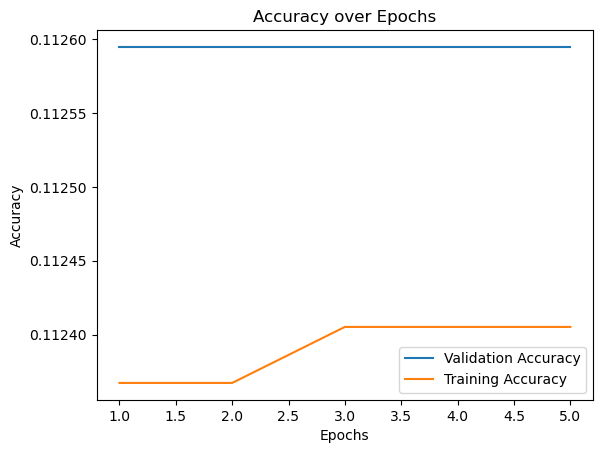

TPR: 0.0
TNR: nan
PPV: nan


C:\Users\akhil\AppData\Local\Temp\ipykernel_109484\1393907376.py:17: RuntimeWarning: invalid value encountered in scalar divide
  return tn / (tn + fp)
C:\Users\akhil\AppData\Local\Temp\ipykernel_109484\591293051.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return tp / (tp + fp)


In [52]:
# TODO 10.1-10.5

X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data(X,y,[1],[0])
perceptron_one_all = Perceptron(alpha=5,epochs=5)
perceptron_one_all.fit(X_trn, y_trn, X_vld, y_vld)

iters = []

for iter in range(len(perceptron_one_all.vld_acc)):
    iters.append(iter+1)

plt.plot(iters, perceptron_one_all.vld_acc, label='Validation Accuracy')
plt.plot(iters, perceptron_one_all.trn_acc, label='Training Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")

plt.show()

y_hat = perceptron_one_all.predict(X_tst)
print(f"TPR: {tpr(y_tst,y_hat)}")
print(f"TNR: {tnr(y_tst,y_hat)}")
print(f"PPV: {ppv(y_tst,y_hat)}")
class_name_key = {-1: 'negative',1: 'positive'}

In [ ]:
# K means

In [55]:
def squared_distances(X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    dist_matrix = None
    # TODO 3.1
    ### BEGIN SOLUTION
    diff = X[:,None] - centroids[None,:]
    dist_matrix = np.sum(diff**2,axis=2)
    ### END SOLUTION
    return dist_matrix

def compute_inertia(X: np.ndarray, centroids: np.ndarray, labels: np.ndarray) -> float:
    inertia_val = 0.0
    # TODO 3.2
    ### BEGIN SOLUTION
    dist_matrix = squared_distances(X, centroids)
    chosen_distances = dist_matrix[np.arange(len(X)), labels]
    inertia_val = np.sum(chosen_distances)
    ### END SOLUTION
    return float(inertia_val)

In [58]:
class KMeans:
    def __init__(self, K=3, max_iters=100, random_state=42):
        self.K = K
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None
        self.inertia_history = []
        self.centroid_history = []

    def initialize_centroids(self, X: np.ndarray) -> np.ndarray:
        centroids = None
        np.random.seed(self.random_state)
        # TODO 4
        ### BEGIN SOLUTION
        indicies = np.random.choice(X.shape[0],self.K,replace=False)
        centroids = X[indicies]
        ### END SOLUTION
        return centroids

In [61]:
class KMeans(KMeans):
    def assign_clusters(self, X: np.ndarray) -> np.ndarray:
        labels = None
        # TODO 5
        ### BEGIN SOLUTION
        labels = np.argmin(squared_distances(X, self.centroids),axis=1)
        ### END SOLUTION
        return labels

In [64]:
class KMeans(KMeans):
    def update_centroids(self, X: np.ndarray) -> np.ndarray:
        new_C = np.zeros((self.K, X.shape[1]))
        # TODO 6
        ### BEGIN SOLUTION
        for k in range(self.K):
            cluster = X[self.labels == k]
            if len(cluster) > 0:
                new_C[k] = np.mean(cluster, axis=0)
            else:
                new_C[k] = self.centroids[k]
        ### END SOLUTION
        return new_C

In [75]:
class KMeans(KMeans):
    def fit(self, X: np.ndarray):
        self.centroids = self.initialize_centroids(X)
        self.centroid_history = [self.centroids.copy()]
        self.inertia_history = []
        self.labels = None

        # TODO 7
        ### BEGIN SOLUTION
        for t in range(self.max_iters):
            old_labels = self.labels
            self.labels = self.assign_clusters(X)
            self.centroids = self.update_centroids(X)
            self.centroid_history.append(self.centroids)
            inertia = compute_inertia(X, self.update_centroids(X), self.labels)
            self.inertia_history.append(inertia)
            if old_labels is not None and np.array_equal(self.labels, old_labels):
                print(f"Converged at iteration {t+1}")
                break
        ### END SOLUTION
        print(f"Stopped at max iteration {self.max_iters}")
        return self

In [77]:
class KMeans(KMeans):
    def predict(self, X: np.ndarray) -> np.ndarray:
        yhat = None
        # TODO 8
        ### BEGIN SOLUTION
        dist_matrix = squared_distances(X, self.centroids)
        yhat = np.argmin(dist_matrix, axis=1)
        yhat = yhat.reshape(yhat.shape[0],1)
        ### END SOLUTION
        return yhat

Converged at iteration 64
Stopped at max iteration 100


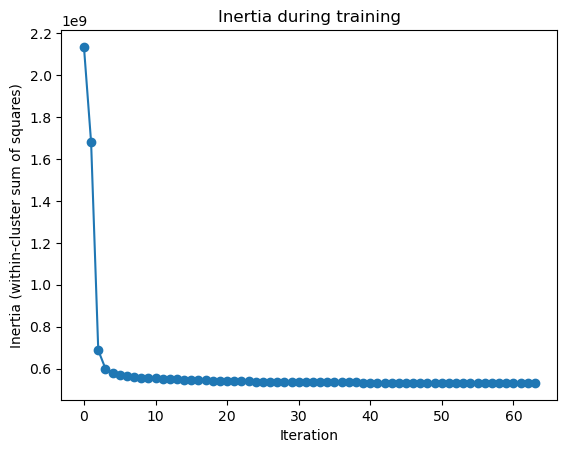

NameError: name 'PCA' is not defined

In [84]:
km3 = KMeans(K=6, max_iters=100, random_state=0)
km3.fit(X)

plt.figure()
plt.plot(km3.inertia_history, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Inertia (within-cluster sum of squares)")
plt.title("Inertia during training")
plt.show()

# PCA projection
pca = PCA(n_components=2, random_state=0)
X_2d = pca.fit_transform(X)
centroids_2d = pca.transform(km3.centroids)

fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharex=True, sharey=True)

# Left: K-means clusters
ax = axes[0]
for k in range(km3.K):
    pts = X_2d[km3.labels == k]
    ax.scatter(pts[:,0], pts[:,1], s=25, alpha=0.85, label=f'cluster {k}')
ax.scatter(centroids_2d[:,0], centroids_2d[:,1], s=180, marker='X', edgecolor='k', linewidth=1.0, label='centroid')
ax.set_title('K-means clusters (PCA space)')
ax.set_xlabel('PC 1'); ax.set_ylabel('PC 2'); ax.legend(fontsize=9, frameon=True)

sil = silhouette_score(X_wine, km3.labels, metric='euclidean')
fig.suptitle(f'Final Inertia: {km3.inertia_history[-1]:.1f}    |    Silhouette: {sil:.3f}', y=1.05, fontsize=12)
plt.tight_layout()
plt.show()